# Exercise 1

### a)

In [1]:
import pandas as pd

In [94]:
train_labels = pd.read_csv('TrainLabels.csv')

### b)

In [3]:
import nltk
import html
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

In [4]:
def remove_hashtags(text):
    text = re.sub(r'#','',text)
    return text

In [5]:
def remove_urls(text):
    text = re.sub(r'http[s]?://\S+|www\.\S+','',text)
    text = re.sub(r'@\w+','',text)
    return text

In [6]:
def xml_lemmatize(text):
    text = html.unescape(text)
    tokens = word_tokenize(text)
    cleaned_tokens = [
        lemmatizer.lemmatize(word.lower()) for word in tokens
        if word.lower() not in stop_words and word.isalpha()
    ]
    return cleaned_tokens

In [7]:
train_labels['cleaned'] = train_labels['tweet']\
    .apply(remove_hashtags)\
    .apply(remove_urls)\
    .apply(xml_lemmatize)


### c)

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

In [10]:
vocabulary = set()
for tweet in train_labels['cleaned']:
    vocabulary.update(tweet)

vocabulary = sorted(vocabulary)

In [11]:
word_to_index = {word: idx for idx, word in enumerate(vocabulary)}

In [12]:
def one_hot_encode(tweet):
    one_hot_vector = [0] * len(vocabulary)
    for word in tweet:
        if word in word_to_index:
            one_hot_vector[word_to_index[word]] = 1
    return one_hot_vector

In [13]:
train_labels['one_hot_encoded'] = train_labels['cleaned'].apply(one_hot_encode)

### d)

In [14]:
from collections import Counter
def bag_of_words(tweet):
    word_counts = Counter(tweet)
    bow_vector = [0] * len(vocabulary)
    for word, count in word_counts.items():
        if word in word_to_index:
            bow_vector[word_to_index[word]] = count
    return bow_vector

In [15]:
train_labels['bow'] = train_labels['cleaned'].apply(bag_of_words)

### e)

In [16]:
from nltk.util import ngrams

In [17]:
def bag_of_ngrams(tokens,n):
    n_grams = list(ngrams(tokens,n))
    ngram_counts = Counter(n_grams)
    ngram_list = [ngram_counts]
    return ngram_list

In [18]:
train_labels['bigrams'] = train_labels['cleaned'].apply(lambda x: bag_of_ngrams(x,n=2))

### f)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
vectorizer = TfidfVectorizer()

In [20]:
train_labels['cleaned_string'] = train_labels['cleaned'].apply(lambda x: ' '.join(x))

In [21]:
tf_vectorizer = TfidfVectorizer(use_idf=False)
tf_matrix = tf_vectorizer.fit_transform(train_labels['cleaned_string'])

In [93]:
idf_vectorizer = TfidfVectorizer(norm=None,use_idf=True,smooth_idf=False)
idf_vectorizer.fit(train_labels['cleaned_string'])
idf_values = idf_vectorizer.idf_
words = idf_vectorizer.get_feature_names_out()
idf_dict = dict(zip(words,idf_values))

In [23]:
tfidf_matrix = vectorizer.fit_transform(train_labels['cleaned_string'])

### g)

In [24]:
import numpy as np

In [25]:
fake_labels = train_labels[train_labels['label'] == 'fake']
real_labels = train_labels[train_labels['label'] == 'real']

In [26]:
from sklearn.metrics.pairwise import cosine_distances
real_labels_tfidf = vectorizer.fit_transform(real_labels['cleaned_string'])
fake_labels_tfidf = vectorizer.fit_transform(fake_labels['cleaned_string'])


In [27]:
real_pairwise_distances = cosine_distances(real_labels_tfidf)
fake_pairwise_distances = cosine_distances(fake_labels_tfidf)

min_real_pairwise = np.min(real_pairwise_distances)
print(min_real_pairwise)

0.0


In [28]:
real_pairwise_distances[np.eye(real_pairwise_distances.shape[0],dtype=bool)] = np.inf
min_distance = np.min(real_pairwise_distances)
min_distance_indices = np.unravel_index(np.argmin(real_pairwise_distances),real_pairwise_distances.shape)
tweet1idx, tweet2idx = min_distance_indices
tweet1 = real_labels.iloc[tweet1idx]['cleaned_string']
tweet2 = real_labels.iloc[tweet2idx]['cleaned_string']
print({tweet1})
print({tweet2})

{'yesterday laboratory completed test testing people managed isolation quarantine routine testing either day stay brings total number test completed date'}
{'yesterday laboratory completed test testing people managed isolation quarantine routine testing either day stay brings total number test completed date'}


In [29]:
def min_nonzero(matrix):
    non_zero_values = matrix[matrix != 0]
    if non_zero_values.size > 0:
        return np.min(non_zero_values)
    else:
        return None

In [30]:
real_min_cosine = min_nonzero(real_pairwise_distances)
print(real_min_cosine)

2.220446049250313e-16


In [31]:
fake_min_cosine = min_nonzero(fake_pairwise_distances)
print(fake_min_cosine)

1.1102230246251565e-16


In [32]:
print("Original Tweet 1:", real_labels.iloc[tweet1idx]['tweet'])
print("Original Tweet 2:", real_labels.iloc[tweet2idx]['tweet'])

Original Tweet 1: Yesterday our laboratories completed 2899 tests of those 726 were testing of people in managed isolation and quarantine for the routine testing on either days 3 or 12 of their stay. That brings the total number of tests completed to date to 436233.
Original Tweet 2: Yesterday our laboratories completed 2061 tests of those 902 were testing of people in managed isolation and quarantine for the routine testing on either days 3 or 12 of their stay. That brings the total number of tests completed to date to 433324.


In [33]:
fake_pairwise_distances[np.eye(fake_pairwise_distances.shape[0],dtype=bool)] = np.inf
min_distance = np.min(fake_pairwise_distances)
min_distance_indices = np.unravel_index(np.argmin(fake_pairwise_distances),fake_pairwise_distances.shape)
fake_tweet1idx, fake_tweet2idx = min_distance_indices
fake_tweet1 = fake_labels.iloc[fake_tweet1idx]['cleaned_string']
fake_tweet2 = fake_labels.iloc[fake_tweet2idx]['cleaned_string']
print(f"Tweet 1: {fake_tweet1}")
print(f"Tweet 2: {fake_tweet2}")

Tweet 1: clearly obama administration leave kind game plan something like
Tweet 2: clearly obama administration leave kind game plan something like


In [34]:
print("Original Tweet 1:", fake_labels.iloc[fake_tweet1idx]['tweet'])
print("Original Tweet 2:", fake_labels.iloc[fake_tweet2idx]['tweet'])

Original Tweet 1: ???Clearly, the Obama administration did not leave any kind of game plan for something like this.??�
Original Tweet 2: “Clearly the Obama administration did not leave any kind of game plan for something like this.”


##### The cosine distances were incredibly small for both the fake labels and the real labels. The pre-processed and cleaned tweets look identical, but upon further inspection we can see that there are differences in the use of numbers and punctuation in the original tweets. The real posts seem to be updating people on Covid statistics, so it makes sense they would follow a consistent format and the only main changes would be the numbers. Again, the numbers would have been removed in pre-processing. The fake tweets seem to have weird and unnecessary punctuation, as well as politically charged messages which may be used for engagement farming. 

# Exercise 2

### a)

### From the Word2Vec file provided via OneDrive:

In [35]:
import os
from time import time

#pre-processing imports
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from string import punctuation

#imports related to modeling
import numpy as np
from gensim.models import Word2Vec, KeyedVectors

In [36]:
#Load the pre-trained word2vec model and the dataset
data_path= "DATAPATH"
%time w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
print('done loading Word2Vec')

CPU times: total: 26.6 s
Wall time: 27.1 s
done loading Word2Vec


In [37]:
tweets_subset = pd.read_csv('TrainLabels.csv')
tweets_subset

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real
...,...,...,...
6415,6416,A tiger tested positive for COVID-19 please st...,fake
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,fake
6417,6418,_A post claims a COVID-19 vaccine has already ...,fake
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,fake


### b)

In [38]:
#strip_handles removes personal information such as twitter handles, which don't
#contribute to emotion in the tweet. preserve_case=False converts everything to lowercase.
tweeter = TweetTokenizer(strip_handles=True,preserve_case=False)
mystopwords = set(stopwords.words("english"))

#Function to tokenize tweets, remove stopwords and numbers. 
#Keeping punctuations and emoticon symbols could be relevant for this task!
def preprocess_corpus(texts):
    def remove_stops_digits(tokens):
        #Nested function that removes stopwords and digits from a list of tokens
        return [token for token in tokens if token not in mystopwords and not token.isdigit()]
    #This return statement below uses the above function to process twitter tokenizer output further. 
    return [remove_stops_digits(tweeter.tokenize(content)) for content in texts]

#df_subset contains only the three categories we chose. 
X = preprocess_corpus(tweets_subset['tweet'])
y = tweets_subset['label']
print(len(X), len(y))

6420 6420


- **Division by Zero**: There's a risk of division by zero in the `embedding_feats` function if `count_for_this` is zero. This can happen if none of the tokens for a given text are found in the Word2Vec model.

- **Checking for Empty Tokens**: Ensure that tokens are not empty before trying to access them in the Word2Vec model.

- **Stopword Removal**: Make sure to remove stopwords before checking if a token is present in the Word2Vec model. Currently, you're checking if the token is in the model first, which might not be efficient.

- **Performance Consideration**: Loading the entire dataset into memory might not be efficient for large datasets. Consider using generators or batching techniques to handle large datasets more efficiently.

- **Feature Vector Calculation**: Ensure that you handle cases where there are no tokens found in the Word2Vec model for a given text.

### c)

In [39]:
def embedding_feats(list_of_lists):
    DIMENSION = 300
    feats = []
    for tokens in list_of_lists:
        feat_for_this = np.zeros(DIMENSION)
        count_for_this = 0
        for token in tokens:
            if token and token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this += 1
        if count_for_this != 0:
            feats.append(feat_for_this / count_for_this)
        else:
            feats.append(np.zeros(DIMENSION))
    return feats

train_vectors = embedding_feats(X)
len(train_vectors)

6420

### d)

In [59]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [67]:
train_vectors_array = np.array(train_vectors)
tsne = TSNE(n_components=2,random_state=42)
train_vectors_2d = tsne.fit_transform(train_vectors_array)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
plt.figure(figsize=(10,8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

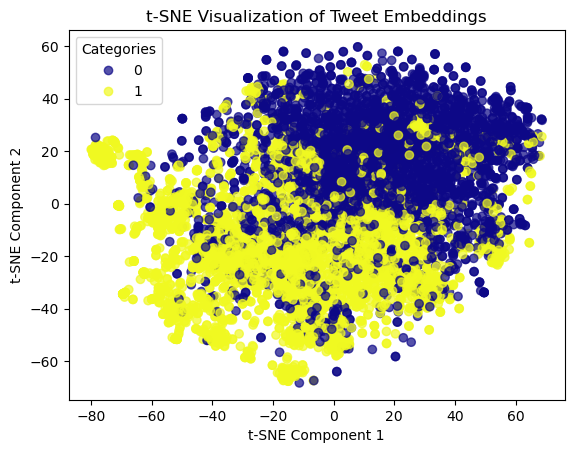

In [92]:
scatter = plt.scatter(train_vectors_2d[:,0],train_vectors_2d[:,1],c=y_encoded,cmap='plasma',alpha=0.7)
plt.title('t-SNE Visualization of Tweet Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(*scatter.legend_elements(),title="Categories")
plt.show()

### e)

In [69]:
from sklearn.decomposition import PCA

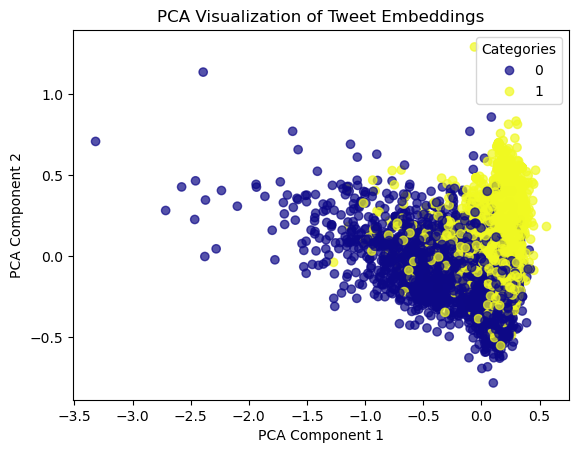

In [70]:
pca = PCA(n_components=2)
train_vectors_pca = pca.fit_transform(train_vectors_array)
scatter = plt.scatter(train_vectors_pca[:,0],train_vectors_pca[:,1],c=y_encoded,cmap='plasma',alpha=0.7)
plt.title('PCA Visualization of Tweet Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(*scatter.legend_elements(),title="Categories")
plt.show()

In [73]:
print(pca.explained_variance_ratio_)

[0.10920824 0.05485385]


### f)

In [87]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

# Assuming train_vectors is a list of post embeddings and y is a list of corresponding labels/classes
# Calculate pairwise cosine distances for each class
class_embeddings = defaultdict(list)
for i, label in enumerate(y):
    class_embeddings[label].append(train_vectors[i])

# Store the pairwise cosine distances for each class
class_cosine_distances = {}
for label, embeddings in class_embeddings.items():
    distances = cosine_similarity(embeddings)
    class_cosine_distances[label] = distances

In [88]:
class_cosine_distances

{'real': array([[1.        , 0.7153504 , 0.28903732, ..., 0.63115639, 0.52311505,
         0.6037877 ],
        [0.7153504 , 1.        , 0.22409864, ..., 0.58120251, 0.48687696,
         0.54856596],
        [0.28903732, 0.22409864, 1.        , ..., 0.4240195 , 0.30288472,
         0.39867751],
        ...,
        [0.63115639, 0.58120251, 0.4240195 , ..., 1.        , 0.46478628,
         0.74510756],
        [0.52311505, 0.48687696, 0.30288472, ..., 0.46478628, 1.        ,
         0.57227246],
        [0.6037877 , 0.54856596, 0.39867751, ..., 0.74510756, 0.57227246,
         1.        ]]),
 'fake': array([[1.        , 0.41668048, 0.51509183, ..., 0.51957649, 0.46093047,
         0.24158954],
        [0.41668048, 1.        , 0.53389743, ..., 0.48922875, 0.4224745 ,
         0.29902773],
        [0.51509183, 0.53389743, 1.        , ..., 0.42080949, 0.38504468,
         0.3464754 ],
        ...,
        [0.51957649, 0.48922875, 0.42080949, ..., 1.        , 0.54389252,
         0.2311322

In [89]:
real_cosine_similarities = []
fake_cosine_similarities = []

for label, distances in class_cosine_distances.items():
    if label == 'real':
        real_cosine_similarities.extend(distances.flatten())
    elif label == 'fake':
        fake_cosine_similarities.extend(distances.flatten())

# Reshape the flattened lists into matrices
num_real_tweets = len(real_cosine_similarities) // len(tweets_subset[tweets_subset['label'] == 'real'])
num_fake_tweets = len(fake_cosine_similarities) // len(tweets_subset[tweets_subset['label'] == 'fake'])

real_cosine_matrix = np.array(real_cosine_similarities).reshape(num_real_tweets, num_real_tweets)
fake_cosine_matrix = np.array(fake_cosine_similarities).reshape(num_fake_tweets, num_fake_tweets)

# Now you have two matrices:
# - real_cosine_matrix: contains cosine similarities for real tweets
# - fake_cosine_matrix: contains cosine similarities for fake tweets

In [90]:
real_cosine_matrix

array([[1.        , 0.7153504 , 0.28903732, ..., 0.63115639, 0.52311505,
        0.6037877 ],
       [0.7153504 , 1.        , 0.22409864, ..., 0.58120251, 0.48687696,
        0.54856596],
       [0.28903732, 0.22409864, 1.        , ..., 0.4240195 , 0.30288472,
        0.39867751],
       ...,
       [0.63115639, 0.58120251, 0.4240195 , ..., 1.        , 0.46478628,
        0.74510756],
       [0.52311505, 0.48687696, 0.30288472, ..., 0.46478628, 1.        ,
        0.57227246],
       [0.6037877 , 0.54856596, 0.39867751, ..., 0.74510756, 0.57227246,
        1.        ]])

In [91]:
# Replace all occurrences of 1 with 0 in the cosine similarity matrices
real_cosine_matrix[real_cosine_matrix > 0.8] = 0
fake_cosine_matrix[fake_cosine_matrix > 0.8] = 0

# Find the indices of the maximum similarity values in each matrix
real_max_indices = np.unravel_index(np.argmax(real_cosine_matrix), real_cosine_matrix.shape)
fake_max_indices = np.unravel_index(np.argmax(fake_cosine_matrix), fake_cosine_matrix.shape)

# Print the tweets with the highest similarities
print("Tweets with highest similarities in real class:")
print("Tweet 1:", tweets_subset['tweet'][real_max_indices[0]])
print("Tweet 2:", tweets_subset['tweet'][real_max_indices[1]])
print("Similarity:", real_cosine_matrix[real_max_indices])

print("\nTweets with highest similarities in fake class:")
print("Tweet 1:", tweets_subset['tweet'][fake_max_indices[0]])
print("Tweet 2:", tweets_subset['tweet'][fake_max_indices[1]])
print("Similarity:", fake_cosine_matrix[fake_max_indices])

Tweets with highest similarities in real class:
Tweet 1: States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths. https://t.co/YASGRTT4ux
Tweet 2: Video shows the first infected patient of COVID-19 at Dhanbad Hospital.
Similarity: 0.7999951160820546

Tweets with highest similarities in fake class:
Tweet 1: Trump said "people are dying who have never died before".
Tweet 2: You can wash your hands ALL day long, use alcohol afterwards and protect yourself from the virus as much as you can .. then this Down pointing backhand index happens at your favourite restaurant and you wonder where the covid-19 is coming from.
Similarity: 0.799879335148602


### g)

##### The PCA visualization shows that the true labeled tweets seem to be closely associated with PCA component 1, but not closely associated with PCA component 2. The bulk of the dots for true labeled tweets are on the right side of the chart and go vertically, so it seems that PCA component 1 explains more of the variability than PCA component 2. Fake labeled tweets seem to almost have a negative linear trend, as there are dots in the top left of the chart that trend downwards and then meet in a large blob in the bottom right of the chart. They also have more outliers on the chart. PCA components 1 and 2 help explain the variability for fake tweets, but the more associated they are with PCA component 1 the less they are associated with PCA component 2. 

##### The t-SNE visualization seems to show that the two components are doing a good job explaining the variability of the fake tweets, especially in comparison to the true tweeets. Overall there is a large cluster in the middle of the chart, but fake tweets form a separate blob to the top right while true tweets form their own blob in the bottom left. There aren't any observed outliers in the t-SNE visualization, which is different than what was observed in the PCA chart. 

##### While these two charts help visualize high-dimensional word embeddings in lower dimensions, they are limited in their scope. t-SNE does not do a good job preserving the global structure and can be computationally expensive. PCA does not do well with non-linear data and is sensitive to scaling. They both are helpful for showing the relationships between true and fake tweets, but they are incomplete measures which should not be the end all be all of your data analysis. 